In [19]:
import tensorflow as tf
import numpy as np
import json


In [20]:
with open('valid.json', 'r') as f:
    data = json.load(f)

def preprocess(data):
    features = []
    labels = []
    for sample in data:
        graph = np.array(sample["graph"], dtype=np.float32)
        label = int(sample["targets"])
        features.append(graph)
        labels.append(label)
    return np.array(features), np.array(labels)

features, labels = preprocess(data)

features = np.stack([features] * 3, axis=-1)  # اضافه کردن 3 کانال

features_resized = tf.image.resize(features, (32, 32)).numpy()


dataset = tf.data.Dataset.from_tensor_slices((features_resized, labels))
dataset = tf.data.Dataset.from_tensor_slices((features_resized, labels)).batch(32)

In [21]:
from sklearn.model_selection import train_test_split

features_train, features_val, labels_train, labels_val = train_test_split(
    features_resized, labels, test_size=0.2, random_state=42
)


train_dataset = tf.data.Dataset.from_tensor_slices((features_train, labels_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((features_val, labels_val)).batch(32)

In [22]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.1),
])
train_dataset_augmented = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)


In [23]:
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    input_shape=(32, 32, 3),
    include_top=False
)

In [24]:
base_model.trainable = False

In [25]:
for layer in base_model.layers[-50:]:
    layer.trainable = True

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [27]:
import tensorflow as tf
import numpy as np
import random

SEED = 42


random.seed(SEED)

np.random.seed(SEED)

tf.random.set_seed(SEED)


In [28]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [37]:
history = model.fit(train_dataset, epochs=20, validation_data=val_dataset)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8289 - loss: 0.4610 - val_accuracy: 0.4776 - val_loss: 0.7651
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8231 - loss: 0.4787 - val_accuracy: 0.4776 - val_loss: 0.7628
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8220 - loss: 0.4624 - val_accuracy: 0.4776 - val_loss: 0.7568
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8171 - loss: 0.4593 - val_accuracy: 0.8060 - val_loss: 0.7757
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8409 - loss: 0.4225 - val_accuracy: 0.4776 - val_loss: 0.8124
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8355 - loss: 0.4239 - val_accuracy: 0.4776 - val_loss: 0.8860
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8346 - loss: 0.4319 - val_accuracy: 0.4776 - val_loss: 0.9178
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8308 - loss: 0.4146 - val_accuracy: 0.8060 - val_loss: 0.9045


In [38]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = (model.predict(features_val) > 0.5).astype(int)
print(confusion_matrix(labels_val, y_pred))
print(classification_report(labels_val, y_pred))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
[[24  7]
 [ 6 30]]
              precision    recall  f1-score   support

           0       0.80      0.77      0.79        31
           1       0.81      0.83      0.82        36

    accuracy                           0.81        67
   macro avg       0.81      0.80      0.80        67
weighted avg       0.81      0.81      0.81        67



In [39]:
import numpy as np
y_pred = (model.predict(features_val) > 0.5).astype(int).flatten()
misclassified = np.where(y_pred != labels_val)[0]
print("Misclassified indices:", misclassified)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
Misclassified indices: [ 4  8 11 12 13 24 28 30 35 40 56 57 63]


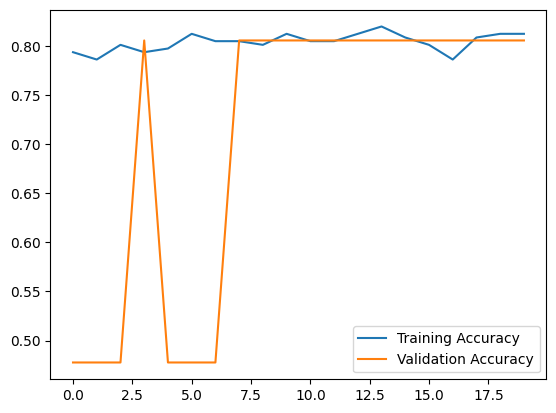

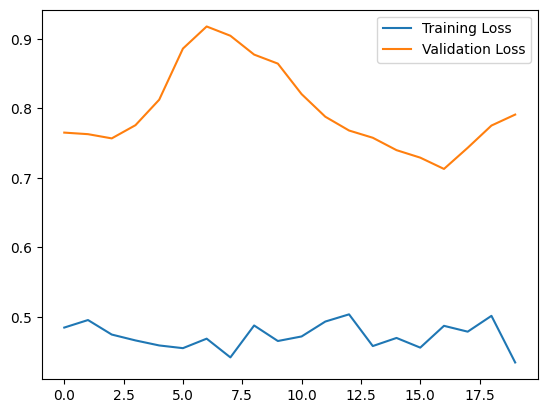

In [40]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

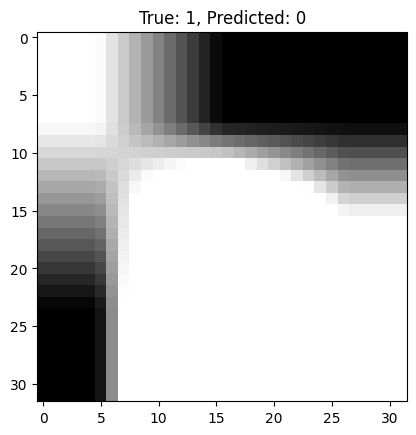

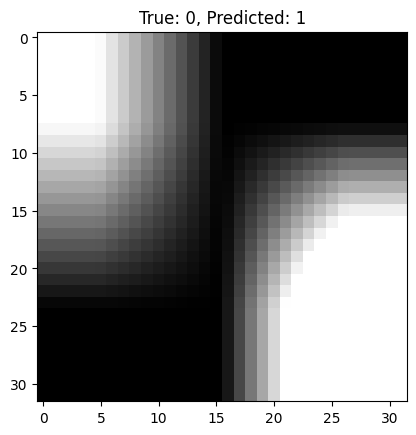

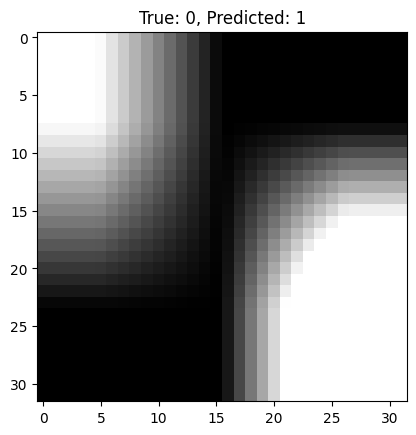

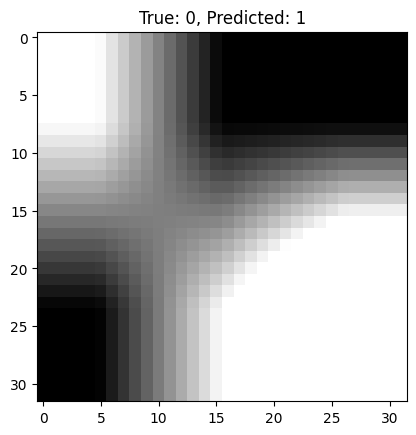

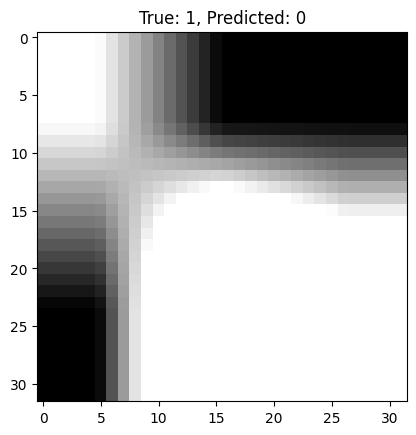

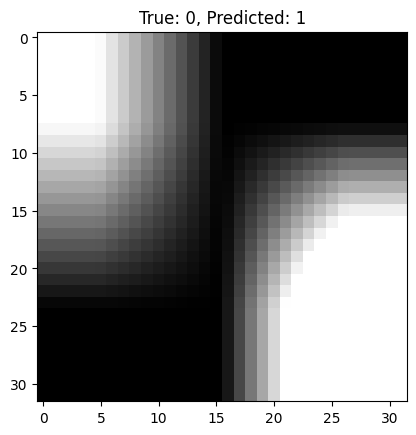

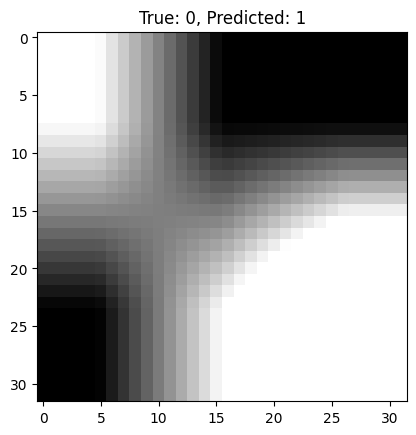

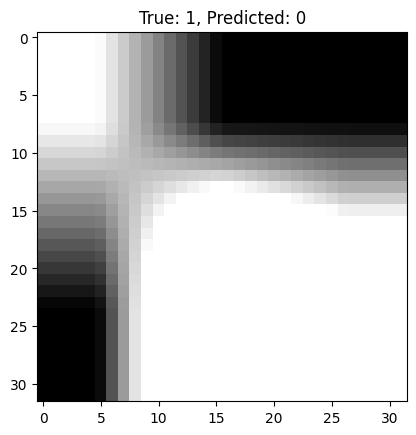

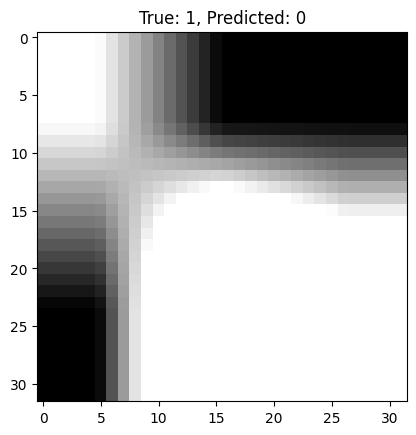

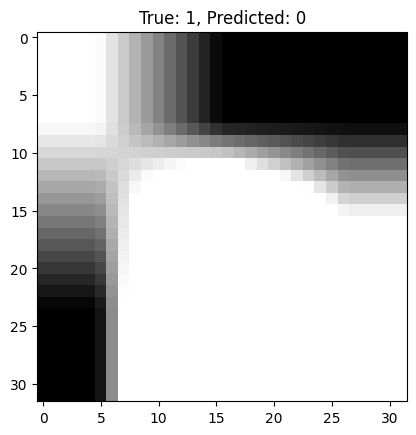

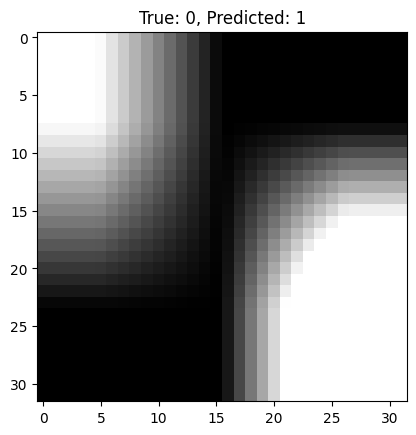

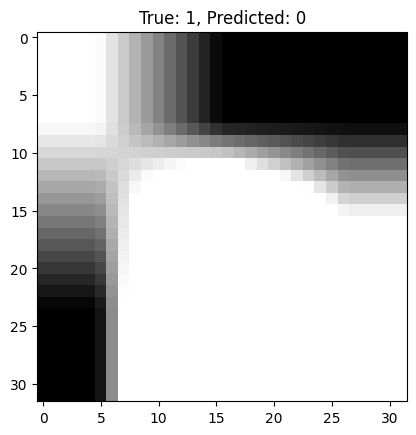

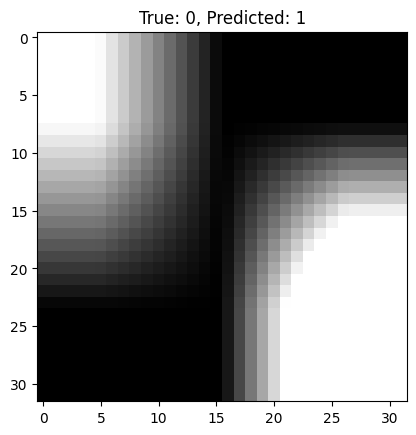

In [41]:
import matplotlib.pyplot as plt

for idx in [4, 8, 11, 12, 13, 24, 28, 30, 35, 40, 56, 57, 63]:
    plt.imshow(features_val[idx])
    plt.title(f"True: {labels_val[idx]}, Predicted: {y_pred[idx]}")
    plt.show()
